<a href="https://colab.research.google.com/github/FrancescoFarinola/AI_in_Industry_CMAPSS/blob/main/cmapss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf AI_in_Industry_CMAPSS
#uncomment previous line to delete github folder

In [2]:
!git clone https://github.com/FrancescoFarinola/AI_in_Industry_CMAPSS

Cloning into 'AI_in_Industry_CMAPSS'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 62 (delta 15), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (62/62), done.


#1. Load and imports

In [3]:
!pip install ipympl &> /dev/null  #&> /dev/null to hide pip install logs

In [4]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow_probability import distributions
from sklearn.metrics import r2_score
from plotly.offline import iplot
import plotly.graph_objs as go
%matplotlib inline
figsize=(20, 3)

sys.path.append('/content/AI_in_Industry_CMAPSS')
from util import cmapss

The function 'interactive_rul_plot' uses the package plotly to plot scatters interactively in order to zoom in/out and move through what we want to explore/analyze.

In [5]:
def interactive_rul_plot(pred,target):
    fig = go.Figure()
    fig.add_traces([go.Scatter(x=np.arange(len(target)), y=target, line=dict(color='orange'), name='target'),
                go.Scatter(x=np.arange(len(pred)), y=pred, line=dict(color='blue'), name='prediction')])
    fig.show()

In [6]:
data_folder = 'AI_in_Industry_CMAPSS/data'
data = cmapss.load_data(data_folder)
data

src  machine  cycle       p1  ...    s19    s20      s21  rul
0      train_FD001        1      1  -0.0007  ...  100.0  39.06  23.4190  191
1      train_FD001        1      2   0.0019  ...  100.0  39.00  23.4236  190
2      train_FD001        1      3  -0.0043  ...  100.0  38.95  23.3442  189
3      train_FD001        1      4   0.0007  ...  100.0  38.88  23.3739  188
4      train_FD001        1      5  -0.0019  ...  100.0  38.90  23.4044  187
...            ...      ...    ...      ...  ...    ...    ...      ...  ...
61244  train_FD004      709    251   9.9998  ...  100.0  29.11  17.5234    4
61245  train_FD004      709    252   0.0028  ...  100.0  39.38  23.7151    3
61246  train_FD004      709    253   0.0029  ...  100.0  39.78  23.8270    2
61247  train_FD004      709    254  35.0046  ...  100.0  15.26   9.0774    1
61248  train_FD004      709    255  42.0030  ...  100.0  10.66   6.4341    0

[160359 rows x 28 columns]

In [7]:
dt_in = list(data.columns[3:-1])
data[dt_in].describe()
data_sv = data.copy()
data_sv[dt_in] = (data_sv[dt_in] - data_sv[dt_in].mean()) / data_sv[dt_in].std()
data_sv_dict = cmapss.split_by_field(data_sv, field='src')
print('{{{}}}'.format(', '.join(f'{k}: ...' for k in data_sv_dict.keys())))

{train_FD001: ..., train_FD002: ..., train_FD003: ..., train_FD004: ...}


**We can analyze the different datasets by simply changing the next cell. Last line will perform analysis on the combination of all the 4 datasets.**

In [8]:
#dt = data_sv_dict['train_FD001']
#dt = data_sv_dict['train_FD002']
#dt = data_sv_dict['train_FD003']
dt = data_sv_dict['train_FD004']
#dt = data

#Base model

This section builds the regressor used in lesson. Mainly used to compare the results with cutted sequences.

##Split

Splits the data according to a ratio.

In [9]:
tr_ratio = 0.75
np.random.seed(42)

machines = dt.machine.unique()
np.random.shuffle(machines)
sep = int(tr_ratio * len(machines))
tr_mcn = machines[:sep]
ts_mcn = machines[sep:]
tr, ts = cmapss.partition_by_machine(dt, tr_mcn)

##Standardization of values

Values of the dataset are standardized with mean and standard deviation.

In [10]:
trmean = tr[dt_in].mean()
trstd = tr[dt_in].std().replace(to_replace=0, value=1) # handle static fields
ts_s = ts.copy()
ts_s[dt_in] = (ts_s[dt_in] - trmean) / trstd
tr_s = tr.copy()
tr_s[dt_in] = (tr_s[dt_in] - trmean) / trstd

##Normalization of RUL

RUL values are normalized.

In [11]:
trmaxrul = tr['rul'].max()
ts_s['rul'] = ts['rul'] / trmaxrul 
tr_s['rul'] = tr['rul'] / trmaxrul 

##Regressor


In [12]:
def build_regressor(hidden):
    input_shape = (len(dt_in), )
    model_in = keras.Input(shape=input_shape, dtype='float32')
    x = model_in
    for h in hidden:
        x = layers.Dense(h, activation='relu')(x)
    model_out = layers.Dense(1, activation='linear')(x)
    model = keras.Model(model_in, model_out)
    return model

cb = [callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

In [13]:
nn = build_regressor(hidden=[32, 32])
nn.compile(optimizer='Adam', loss='mse')
history = nn.fit(tr_s[dt_in], tr_s['rul'], validation_split=0.2,
                 callbacks=cb, batch_size=32, epochs=20, verbose=1)

Epoch 1/20
1135/1135 [==============================] - 3s 2ms/step - loss: 0.0200 - val_loss: 0.0128
Epoch 2/20
1135/1135 [==============================] - 2s 2ms/step - loss: 0.0156 - val_loss: 0.0136
Epoch 3/20
1135/1135 [==============================] - 2s 2ms/step - loss: 0.0146 - val_loss: 0.0126
Epoch 4/20
1135/1135 [==============================] - 2s 2ms/step - loss: 0.0144 - val_loss: 0.0120
Epoch 5/20
1135/1135 [==============================] - 2s 2ms/step - loss: 0.0143 - val_loss: 0.0113
Epoch 6/20
1135/1135 [==============================] - 2s 2ms/step - loss: 0.0141 - val_loss: 0.0111
Epoch 7/20
1135/1135 [==============================] - 2s 2ms/step - loss: 0.0139 - val_loss: 0.0109
Epoch 8/20
1135/1135 [==============================] - 2s 2ms/step - loss: 0.0138 - val_loss: 0.0112
Epoch 9/20
1135/1135 [==============================] - 2s 2ms/step - loss: 0.0138 - val_loss: 0.0106
Epoch 10/20
1135/1135 [==============================] - 2s 2ms/step - loss: 0.013

Final loss: 0.0133 (training), 0.0101 (validation)


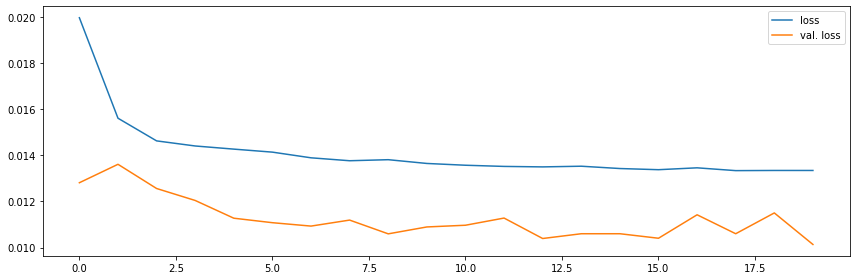

In [14]:
cmapss.plot_training_history(history, figsize=(12,4))
trl, vll = history.history["loss"][-1], np.min(history.history["val_loss"])
print(f'Final loss: {trl:.4f} (training), {vll:.4f} (validation)')

R2 score: 0.5440785594245716


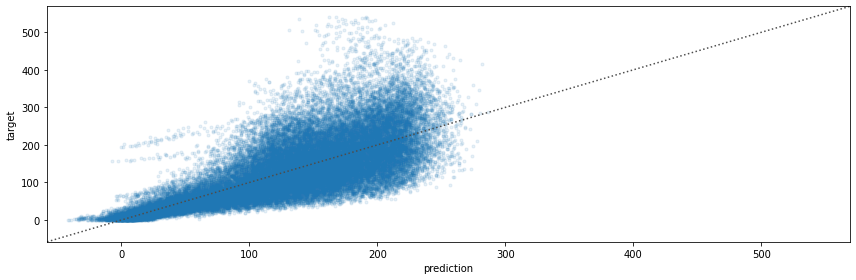

In [15]:
tr_pred = nn.predict(tr_s[dt_in]).ravel() * trmaxrul
cmapss.plot_pred_scatter(tr_pred, tr['rul'], figsize=(12,4))
print(f'R2 score: {r2_score(tr["rul"], tr_pred)}')

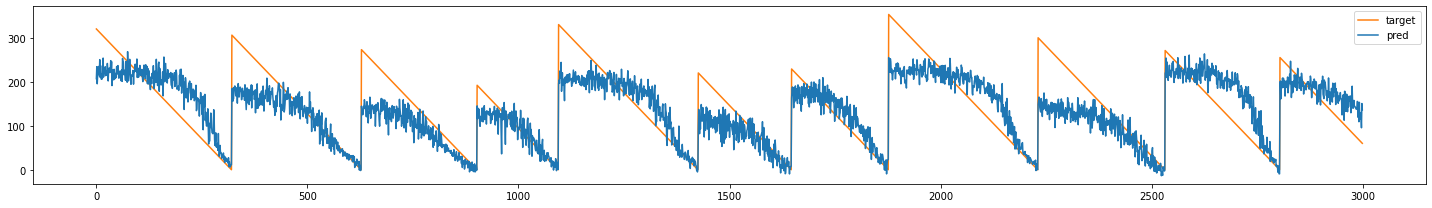

In [16]:
stop=3000
cmapss.plot_rul(tr_pred[:stop], tr['rul'][:stop], figsize=figsize)

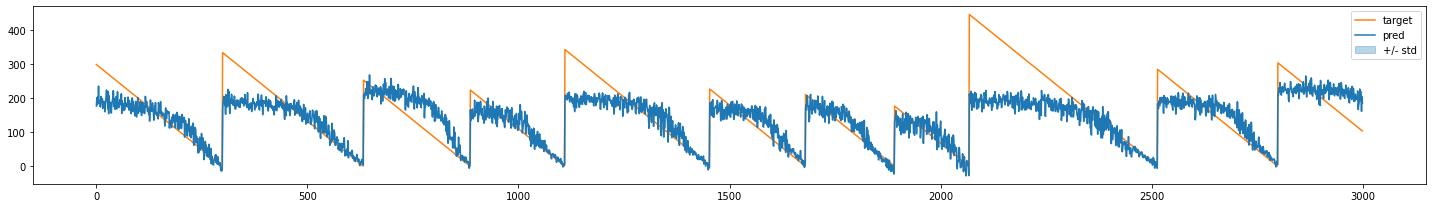

In [17]:
ts_pred = nn.predict(ts_s[dt_in]).ravel() * trmaxrul
cmapss.plot_rul(ts_pred[:stop], ts['rul'][:stop], figsize=figsize, stddev=0.01)

In [18]:
tr_pred = nn.predict(tr_s[dt_in]).ravel() * trmaxrul
interactive_rul_plot(tr_pred, tr['rul'])

In [19]:
interactive_rul_plot(ts_pred, ts['rul'])

##Cost model and Evaluation

In [20]:
failtimes = dt.groupby('machine')['cycle'].max()
safe_interval = failtimes.min()
maintenance_cost = failtimes.max()

Optimal threshold for the training set: 7


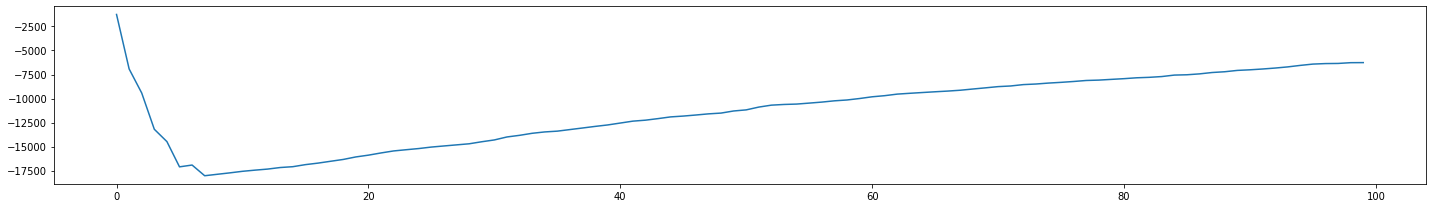

In [21]:
cmodel = cmapss.RULCostModel(maintenance_cost=maintenance_cost, safe_interval=safe_interval)
th_range = np.arange(0, 100)
tr_thr = cmapss.opt_threshold_and_plot(tr['machine'].values, tr_pred, th_range, cmodel, figsize=figsize)
print(f'Optimal threshold for the training set: {tr_thr}')

In [22]:
tr_c, tr_f, tr_sl = cmodel.cost(tr['machine'].values, tr_pred, tr_thr, return_margin=True)
ts_c, ts_f, ts_sl = cmodel.cost(ts['machine'].values, ts_pred, tr_thr, return_margin=True)
print(f'Cost: {tr_c} (training), {ts_c} (test)')
print(f'Avg. fails: {tr_f/len(tr_mcn)} (training), {ts_f/len(ts_mcn)} (test)')
print(f'Avg. slack: {tr_sl/len(tr_mcn):.2f} (training), {ts_sl/len(ts_mcn):.2f} (test)')

Cost: -18039 (training), -6822 (test)
Avg. fails: 0.0 (training), 0.0 (test)
Avg. slack: 19.37 (training), 15.65 (test)


# Sequences of equal length

Distribution of cycle length

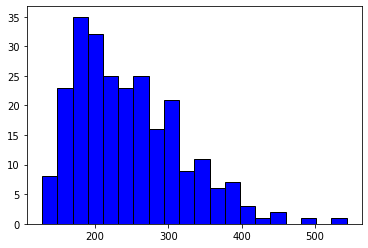

In [23]:
failtimes = dt.groupby('machine')['cycle'].max()
plt.hist(failtimes, color = 'blue', edgecolor = 'black', bins=20);

We used failtimes.min() to get the minimum sequence length. Also, we calculated the average length of all cycles to compare it with the minimum in case the minimum sequence length was too short with respect to all the others. This was made to prevent from cutting most of the data. 

In [24]:
min_sequence = failtimes.min()
mean_sequence = failtimes.mean()
print("Minimum sequence length: " + str(min_sequence))
print("Average sequence length: " + str(mean_sequence))

Minimum sequence length: 128
Average sequence length: 245.97991967871485


In [25]:
#Cuts the sequences
tr_e = tr[tr['rul']<=min_sequence] 
ts_e = ts[ts['rul']<=min_sequence]

## Standardization / Normalization

Data has to be standardized and normalized according to the new range of values in the data.

In [26]:
trmean_e = tr_e[dt_in].mean()
trstd_e = tr_e[dt_in].std().replace(to_replace=0, value=1) # handle static fields
tr_e_s = tr_e.copy()
tr_e_s[dt_in] = (tr_e_s[dt_in] - trmean_e) / trstd_e
ts_e_s = ts_e.copy()
ts_e_s[dt_in] = (ts_e_s[dt_in] - trmean_e) / trstd_e

trmaxrul_e = tr_e['rul'].max()
tr_e_s['rul'] = tr_e['rul'] / trmaxrul_e 
ts_e_s['rul'] = ts_e['rul'] / trmaxrul_e

##Regressor

In [27]:
nn1 = build_regressor(hidden=[32, 32])
nn1.compile(optimizer='Adam', loss='mse')
history1 = nn1.fit(tr_e_s[dt_in], tr_e_s['rul'], validation_split=0.2,
                 callbacks=cb, batch_size=32, epochs=20, verbose=1)

Epoch 1/20
600/600 [==============================] - 2s 2ms/step - loss: 0.0707 - val_loss: 0.0440
Epoch 2/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0398 - val_loss: 0.0359
Epoch 3/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0349 - val_loss: 0.0322
Epoch 4/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0338 - val_loss: 0.0343
Epoch 5/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0326 - val_loss: 0.0303
Epoch 6/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0317 - val_loss: 0.0329
Epoch 7/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0308 - val_loss: 0.0273
Epoch 8/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0305 - val_loss: 0.0269
Epoch 9/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0299 - val_loss: 0.0318
Epoch 10/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0295 - val_loss: 0.0294

Final loss: 0.0276 (training), 0.0241 (validation)


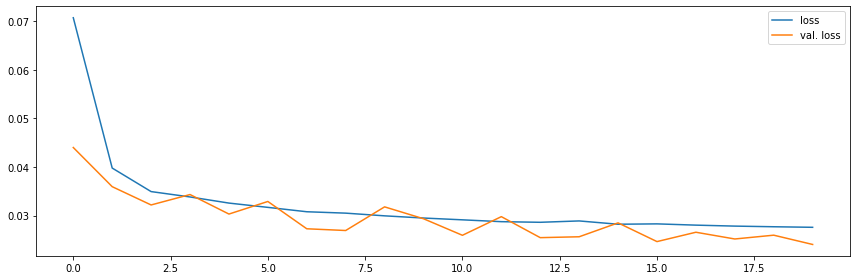

In [28]:
cmapss.plot_training_history(history1, figsize=(12,4))
trl1, vll1 = history1.history["loss"][-1], np.min(history1.history["val_loss"])
print(f'Final loss: {trl1:.4f} (training), {vll1:.4f} (validation)')

R2 score: 0.696107773003849


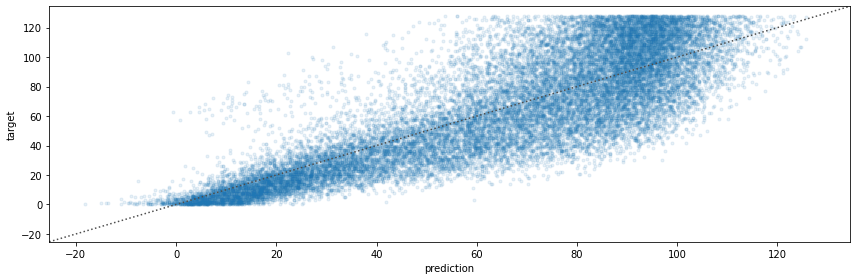

In [29]:
tr_pred1 = nn1.predict(tr_e_s[dt_in]).ravel() * trmaxrul_e
cmapss.plot_pred_scatter(tr_pred1, tr_e['rul'], figsize=(12,4))
print(f'R2 score: {r2_score(tr_e["rul"], tr_pred1)}')

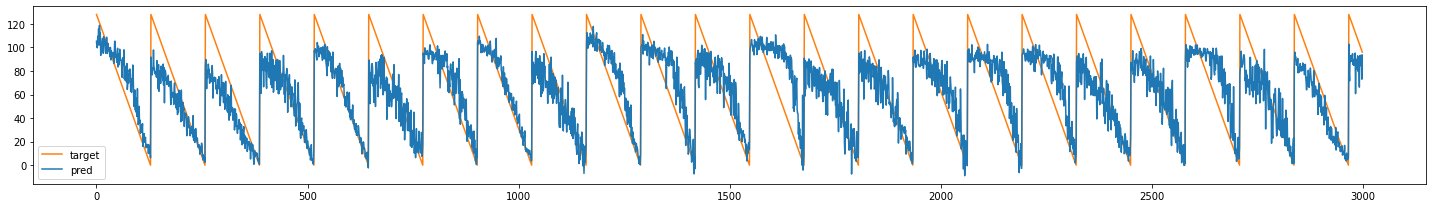

In [30]:
cmapss.plot_rul(tr_pred1[:stop], tr_e['rul'][:stop], figsize=figsize)

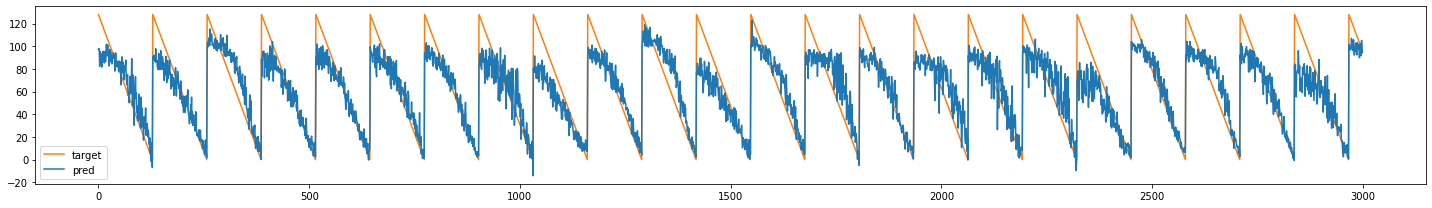

In [31]:
ts_pred1 = nn1.predict(ts_e_s[dt_in]).ravel() * trmaxrul_e
cmapss.plot_rul(ts_pred1[:stop], ts_e['rul'][:stop], figsize=figsize)

In [32]:
interactive_rul_plot(tr_pred1, tr_e['rul'])

In [33]:
interactive_rul_plot(ts_pred1, ts_e['rul'])

##Cost model and Evaluation

We have created a new cost model since the maintenance_cost and safe_interval now have the same value (128). This would reduce the general profit to 0 in every case, so we cannot compare results relative the accuracy of the model in terms of cost but only in terms of average fails and slack.

Optimal threshold for the training set: 9


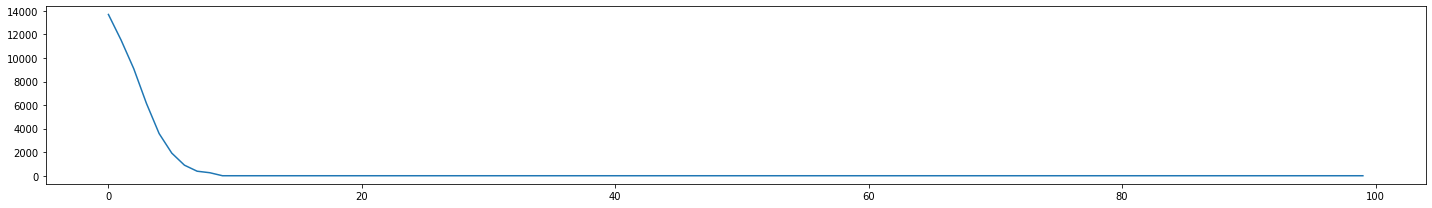

In [34]:
cmodel1 = cmapss.RULCostModel(maintenance_cost=min_sequence, safe_interval=min_sequence)
th_range = np.arange(0, 100)
tr_thr1 = cmapss.opt_threshold_and_plot(tr_e_s['machine'].values, tr_pred1, th_range, cmodel1, figsize=figsize)
print(f'Optimal threshold for the training set: {tr_thr1}')

In [35]:
tr_equal_c, tr_equal_f, tr_equal_sl = cmodel1.cost(tr_e['machine'].values, tr_pred1, tr_thr1, return_margin=True)
ts_equal_c, ts_equal_f, ts_equal_sl = cmodel1.cost(ts_e['machine'].values, ts_pred1, tr_thr1, return_margin=True)
print(f'Cost: {tr_equal_c} (training), {ts_equal_c} (test)')
print(f'Avg. fails: {tr_equal_f/len(tr_mcn)} (training), {ts_equal_f/len(ts_mcn)} (test)')
print(f'Avg. slack: {tr_equal_sl/len(tr_mcn):.2f} (training), {ts_equal_sl/len(ts_mcn):.2f} (test)')

Cost: 0 (training), 0 (test)
Avg. fails: 0.0 (training), 0.0 (test)
Avg. slack: 10.66 (training), 9.48 (test)


## Comparing results

In order to compare results we have to analyze the predictions of same experiments.

We have chosen a section of the dataset which includes experiments with very different sequence lengths (from row 19000 to 22000 of the dataset) in order to take into account some generalization.

The variable 'mc' stores the values of the machines included in the analysis, so as to plot the predictions relative only to that experiments.

### Training set comparison

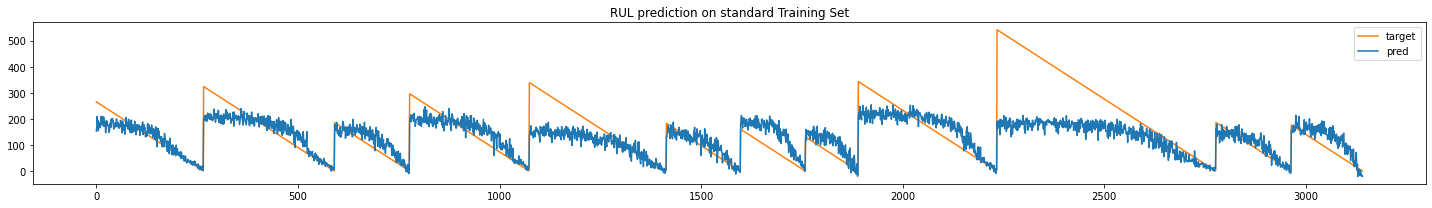

In [36]:
mc_t = tr['machine'][19000:22000].unique() #stores the values of machines between two certain values.
tr_s1 = tr_s[tr_s.machine.isin(mc_t)]
tr_pred = nn.predict(tr_s1[dt_in]).ravel() * trmaxrul
cmapss.plot_rul(tr_pred, tr[tr.machine.isin(mc_t)]['rul'], figsize=figsize, title='RUL prediction on standard Training Set')

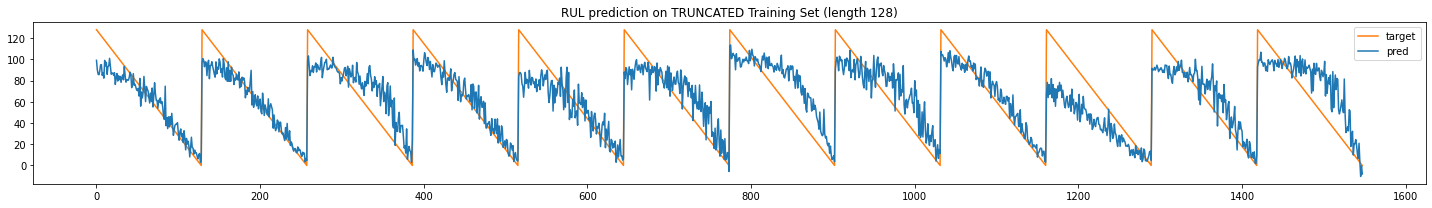

In [37]:
tr_e_s = tr_e_s[tr_e_s.machine.isin(mc_t)] #get test data only of the machines analyzed
tr_pred1 = nn1.predict(tr_e_s[dt_in]).ravel() * trmaxrul_e #predict only values of selected machines
cmapss.plot_rul(tr_pred1, tr_e[tr_e.machine.isin(mc_t)]['rul'], figsize=figsize, title='RUL prediction on TRUNCATED Training Set (length 128)')

### Test set comparison

Like we did for training set, we choose a section of the test set with different cycle lengths and plot the predictions of the same experiments. 

In this case the first 11 experiments are enough different.

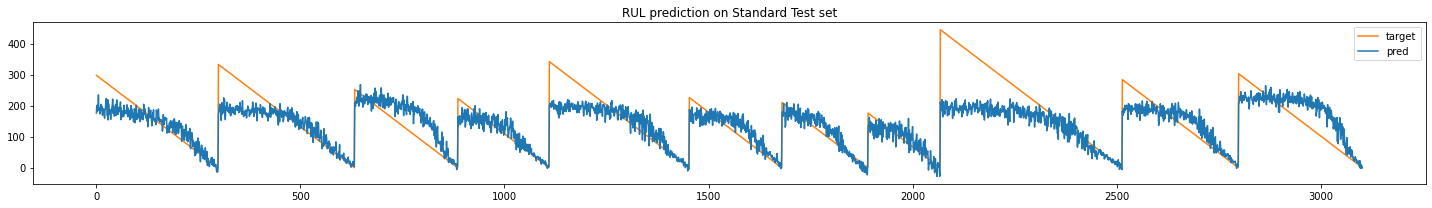

In [38]:
mc_ts = ts['machine'][:3000].unique()
ts_s1 = ts_s[ts_s.machine.isin(mc_ts)]
ts_pred = nn.predict(ts_s1[dt_in]).ravel() * trmaxrul
cmapss.plot_rul(ts_pred, ts[ts.machine.isin(mc_ts)]['rul'], figsize=figsize, title='RUL prediction on Standard Test set')

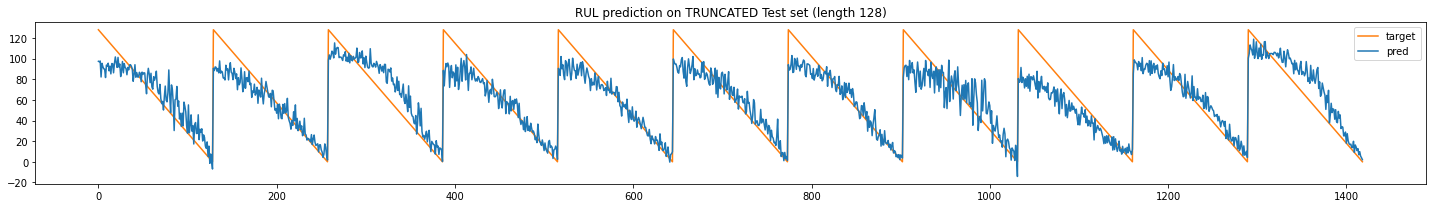

In [39]:
ts_e_s = ts_e_s[ts_e_s.machine.isin(mc_ts)]
ts_pred1 = nn1.predict(ts_e_s[dt_in]).ravel() * trmaxrul_e
cmapss.plot_rul(ts_pred1, ts_e[ts_e.machine.isin(mc_ts)]['rul'], figsize=figsize, title='RUL prediction on TRUNCATED Test set (length 128)')

What comes out from this comparison is that in shorter experiments we still have some 'flat' predictions while in longer experiments the fault seems to be already risen up. 

## Further shortening of sequences

We can prove that the defect arises around half of the experiment with a counterexample by further shortening of sequences. Theoretically, 'flat' predictions should vanish totally.

### Min_sequence = 90

First, we assume the maximum cycle length is 90. So, we re-standardize/re-normalize our data based on values of sequences of this length and build again the regressor.

In [40]:
min_sequence = 90
tr_e1 = tr[tr['rul']<=min_sequence] 
ts_e1 = ts[ts['rul']<=min_sequence]

#Standardization
trmean_e1 = tr_e1[dt_in].mean()
trstd_e1 = tr_e1[dt_in].std().replace(to_replace=0, value=1) # handle static fields
tr_e1_s = tr_e1.copy()
tr_e1_s[dt_in] = (tr_e1_s[dt_in] - trmean_e1) / trstd_e1
ts_e1_s = ts_e1.copy()
ts_e1_s[dt_in] = (ts_e1_s[dt_in] - trmean_e1) / trstd_e1

#Normalization
trmaxrul_e1 = tr_e1['rul'].max()
tr_e1_s['rul'] = tr_e1['rul'] / trmaxrul_e1 
ts_e1_s['rul'] = ts_e1['rul'] / trmaxrul_e1

In [41]:
nn2 = build_regressor(hidden=[32, 32])
nn2.compile(optimizer='Adam', loss='mse')
history2 = nn2.fit(tr_e1_s[dt_in], tr_e1_s['rul'], validation_split=0.2,
                 callbacks=cb, batch_size=32, epochs=20, verbose=1)

Epoch 1/20
424/424 [==============================] - 1s 2ms/step - loss: 0.0759 - val_loss: 0.0575
Epoch 2/20
424/424 [==============================] - 1s 2ms/step - loss: 0.0495 - val_loss: 0.0396
Epoch 3/20
424/424 [==============================] - 1s 2ms/step - loss: 0.0407 - val_loss: 0.0325
Epoch 4/20
424/424 [==============================] - 1s 2ms/step - loss: 0.0365 - val_loss: 0.0329
Epoch 5/20
424/424 [==============================] - 1s 2ms/step - loss: 0.0338 - val_loss: 0.0289
Epoch 6/20
424/424 [==============================] - 1s 2ms/step - loss: 0.0328 - val_loss: 0.0341
Epoch 7/20
424/424 [==============================] - 1s 2ms/step - loss: 0.0321 - val_loss: 0.0285
Epoch 8/20
424/424 [==============================] - 1s 2ms/step - loss: 0.0311 - val_loss: 0.0255
Epoch 9/20
424/424 [==============================] - 1s 2ms/step - loss: 0.0314 - val_loss: 0.0276
Epoch 10/20
424/424 [==============================] - 1s 2ms/step - loss: 0.0303 - val_loss: 0.0258

R2 score: 0.6858115360723986


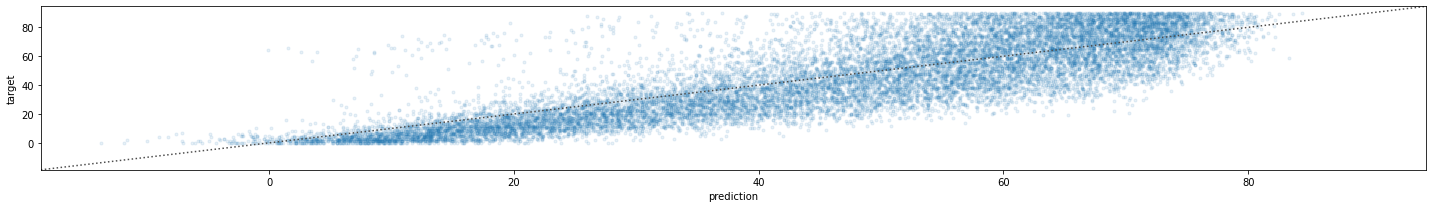

In [42]:
tr_pred2 = nn2.predict(tr_e1_s[dt_in]).ravel() * trmaxrul_e1
ts_pred2 = nn2.predict(ts_e1_s[dt_in]).ravel() * trmaxrul_e1
cmapss.plot_pred_scatter(tr_pred2, tr_e1['rul'], figsize=figsize)
print(f'R2 score: {r2_score(tr_e1["rul"], tr_pred2)}')

Optimal threshold for the training set: 16


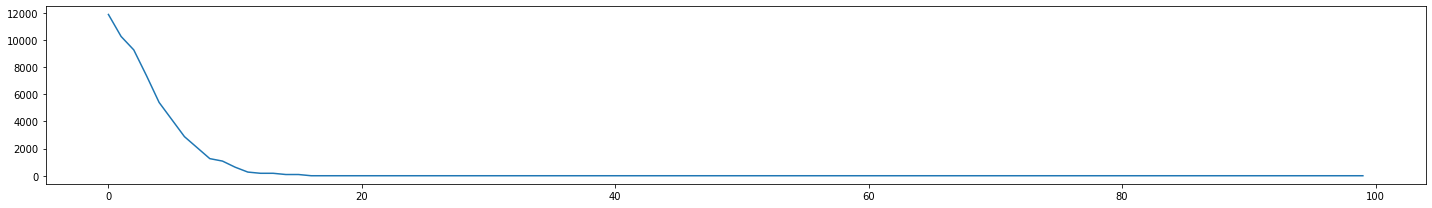

In [43]:
cmodel2 = cmapss.RULCostModel(maintenance_cost=min_sequence, safe_interval=min_sequence)
th_range = np.arange(0, 100)
tr_thr2 = cmapss.opt_threshold_and_plot(tr_e1_s['machine'].values, tr_pred2, th_range, cmodel2, figsize=figsize)
print(f'Optimal threshold for the training set: {tr_thr2}')

In [44]:
tr_equal1_c, tr_equal1_f, tr_equal1_sl = cmodel2.cost(tr_e1['machine'].values, tr_pred2, tr_thr2, return_margin=True)
ts_equal1_c, ts_equal1_f, ts_equal1_sl = cmodel2.cost(ts_e1['machine'].values, ts_pred2, tr_thr2, return_margin=True)
print(f'Cost: {tr_equal1_c} (training), {ts_equal1_c} (test)')
print(f'Avg. fails: {tr_equal1_f/len(tr_mcn)} (training), {ts_equal1_f/len(ts_mcn)} (test)')
print(f'Avg. slack: {tr_equal1_sl/len(tr_mcn):.2f} (training), {ts_equal1_sl/len(ts_mcn):.2f} (test)')

Cost: 0 (training), 0 (test)
Avg. fails: 0.0 (training), 0.0 (test)
Avg. slack: 14.86 (training), 14.22 (test)


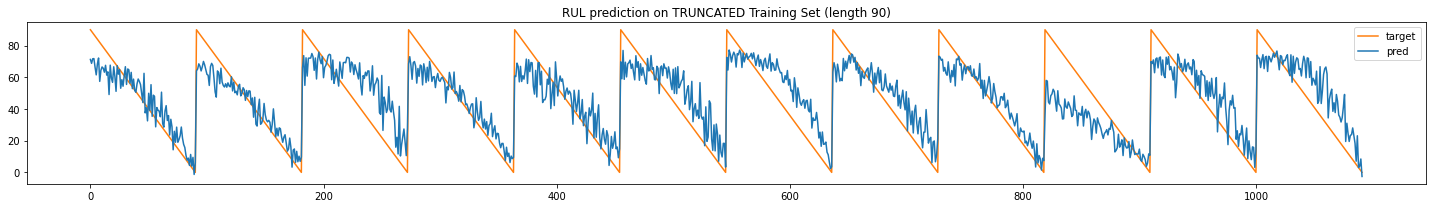

In [45]:
tr_e1_s = tr_e1_s[tr_e1_s.machine.isin(mc_t)]
tr_pred2 = nn2.predict(tr_e1_s[dt_in]).ravel() * trmaxrul_e1
cmapss.plot_rul(tr_pred2, tr_e1[tr_e1.machine.isin(mc_t)]['rul'], figsize=figsize, title='RUL prediction on TRUNCATED Training Set (length 90)')

Still, in the 3rd and last two experiment (shorter ones) we see some 'flat' predictions.

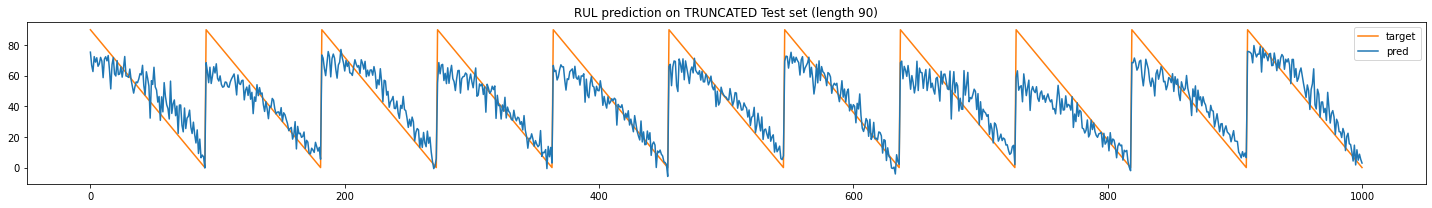

In [46]:
ts_e1_s = ts_e1_s[ts_e1_s.machine.isin(mc_ts)]
ts_pred2 = nn2.predict(ts_e1_s[dt_in]).ravel() * trmaxrul_e1
cmapss.plot_rul(ts_pred2, ts_e1[ts_e1.machine.isin(mc_ts)]['rul'], figsize=figsize, title='RUL prediction on TRUNCATED Test set (length 90)')

### Min_sequence = 50

By using 50 as min_sequence, which is less than half of 128 (the original minimum sequence length), the fault should be already risen up in all experiments.

In [47]:
min_sequence = 50
tr_e2 = tr[tr['rul']<=min_sequence] 
ts_e2 = ts[ts['rul']<=min_sequence]

#Standardization
trmean_e2 = tr_e2[dt_in].mean()
trstd_e2 = tr_e2[dt_in].std().replace(to_replace=0, value=1) # handle static fields
tr_e2_s = tr_e2.copy()
tr_e2_s[dt_in] = (tr_e2_s[dt_in] - trmean_e2) / trstd_e2
ts_e2_s = ts_e2.copy()
ts_e2_s[dt_in] = (ts_e2_s[dt_in] - trmean_e2) / trstd_e2

#Normalization
trmaxrul_e2 = tr_e2['rul'].max()
tr_e2_s['rul'] = tr_e2['rul'] / trmaxrul_e2 
ts_e2_s['rul'] = ts_e2['rul'] / trmaxrul_e2

In [48]:
nn3 = build_regressor(hidden=[32, 32])
nn3.compile(optimizer='Adam', loss='mse')
history3 = nn3.fit(tr_e2_s[dt_in], tr_e2_s['rul'], validation_split=0.2,
                 callbacks=cb, batch_size=32, epochs=20, verbose=1)

Epoch 1/20
238/238 [==============================] - 1s 2ms/step - loss: 0.1072 - val_loss: 0.0730
Epoch 2/20
238/238 [==============================] - 0s 2ms/step - loss: 0.0661 - val_loss: 0.0610
Epoch 3/20
238/238 [==============================] - 0s 2ms/step - loss: 0.0582 - val_loss: 0.0544
Epoch 4/20
238/238 [==============================] - 0s 2ms/step - loss: 0.0523 - val_loss: 0.0458
Epoch 5/20
238/238 [==============================] - 0s 2ms/step - loss: 0.0456 - val_loss: 0.0420
Epoch 6/20
238/238 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0377
Epoch 7/20
238/238 [==============================] - 0s 2ms/step - loss: 0.0381 - val_loss: 0.0377
Epoch 8/20
238/238 [==============================] - 0s 2ms/step - loss: 0.0369 - val_loss: 0.0335
Epoch 9/20
238/238 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0309
Epoch 10/20
238/238 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0311

R2 score: 0.6362677756153963


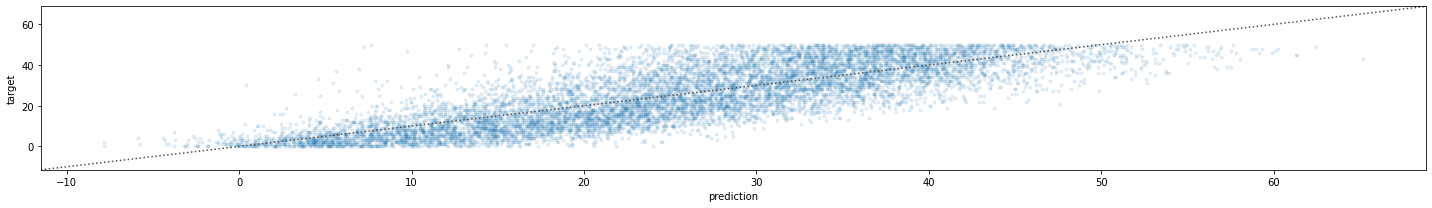

In [49]:
tr_pred3 = nn3.predict(tr_e2_s[dt_in]).ravel() * trmaxrul_e2
ts_pred3 = nn3.predict(ts_e2_s[dt_in]).ravel() * trmaxrul_e2
cmapss.plot_pred_scatter(tr_pred3, tr_e2['rul'], figsize=figsize)
print(f'R2 score: {r2_score(tr_e2["rul"], tr_pred3)}')

Optimal threshold for the training set: 14


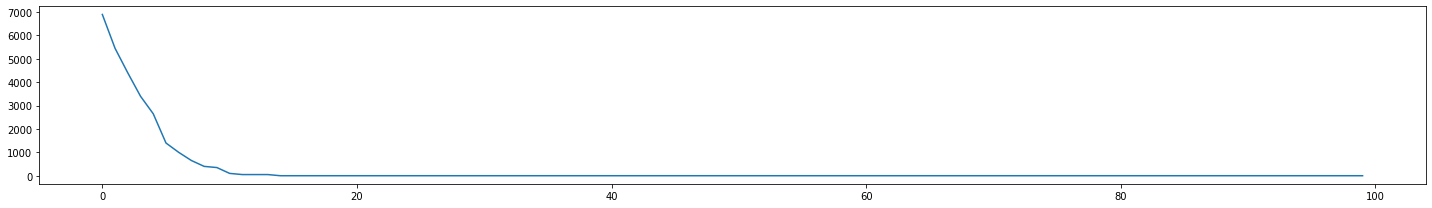

In [50]:
cmodel3 = cmapss.RULCostModel(maintenance_cost=min_sequence, safe_interval=min_sequence)
th_range = np.arange(0, 100)
tr_thr3 = cmapss.opt_threshold_and_plot(tr_e2_s['machine'].values, tr_pred3, th_range, cmodel3, figsize=figsize)
print(f'Optimal threshold for the training set: {tr_thr3}')

In [51]:
tr_equal2_c, tr_equal2_f, tr_equal2_sl = cmodel3.cost(tr_e2['machine'].values, tr_pred3, tr_thr3, return_margin=True)
ts_equal2_c, ts_equal2_f, ts_equal2_sl = cmodel3.cost(ts_e2['machine'].values, ts_pred3, tr_thr3, return_margin=True)
print(f'Cost: {tr_equal2_c} (training), {ts_equal2_c} (test)')
print(f'Avg. fails: {tr_equal2_f/len(tr_mcn)} (training), {ts_equal2_f/len(ts_mcn)} (test)')
print(f'Avg. slack: {tr_equal2_sl/len(tr_mcn):.2f} (training), {ts_equal2_sl/len(ts_mcn):.2f} (test)')

Cost: 0 (training), 0 (test)
Avg. fails: 0.0 (training), 0.0 (test)
Avg. slack: 17.33 (training), 17.73 (test)


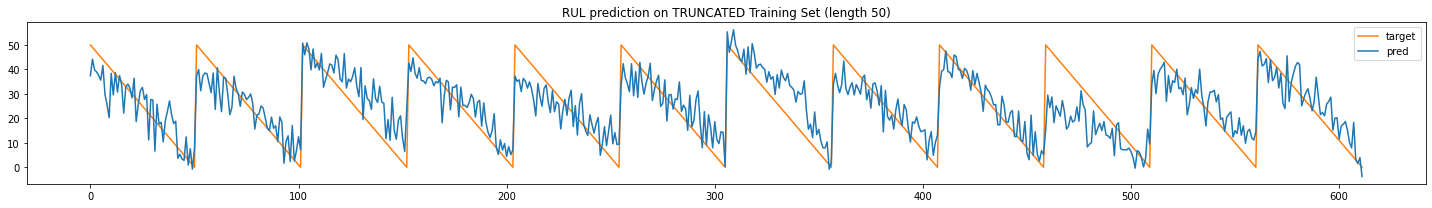

In [52]:
tr_e2_s = tr_e2_s[tr_e2_s.machine.isin(mc_t)]
tr_pred3 = nn3.predict(tr_e2_s[dt_in]).ravel() * trmaxrul_e2
cmapss.plot_rul(tr_pred3, tr_e2[tr_e2.machine.isin(mc_t)]['rul'], figsize=figsize, title='RUL prediction on TRUNCATED Training Set (length 50)')

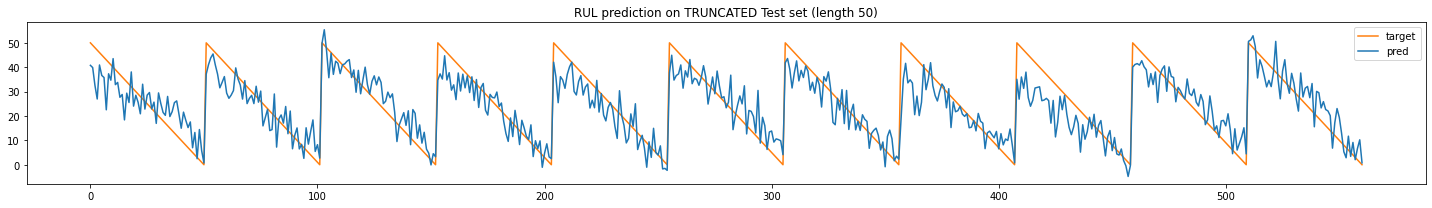

In [53]:
ts_e2_s = ts_e2_s[ts_e2_s.machine.isin(mc_ts)]
ts_pred3 = nn3.predict(ts_e2_s[dt_in]).ravel() * trmaxrul_e2
cmapss.plot_rul(ts_pred3, ts_e2[ts_e2.machine.isin(mc_ts)]['rul'], figsize=figsize, title='RUL prediction on TRUNCATED Test set (length 50)')

By looking at these results, we can conclude that the initial 'plateau' in the base model predictions is due to the absence of faults.

#Paper Analysis

To prove this, we looked better at how data of sensors in generated from the paper "*Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation*" by Abhinav Saxena, Kai Goebel, Don Simon, Neil Eklund.


What comes out is that there is likely no fault that arises suddently, but the life of an engine decreases due to the progressive usage of it based on different amount and rate of damage accumulation, like the fault increases exponentially for all the duration of the experiment.   

We can prove this by looking at the process of data generation:


1.   Choose initial deterioration $(f_0, e_0)$ where $f_0 \in [0.99,1]$ and $e_0 \in [0.99,1]$. 
This initial wear can occur due to manufacturing and assembly variations and is modelled in flow and efficiencies of the various modules. Those values are taken from a random distribution, such that the maximum initial deterioration is bounded within 1% degradation of the healthy condition.

2.   Impose an exponential rate of change for flow and efficiency loss for each dataset, denoting an otherwise unspecified fault with increasingly worsening effect as: 
\begin{equation}
  h(t) =  1 - exp\{at^b\}
\end{equation}
This results in the overall health index:
\begin{equation}
H(t)=g(e(t),f(t))
\end{equation} 
varying as a function of time where:
\begin{equation}
e(t)=1-d_e-exp\{a_e(t)t^{b_e(t)}\}
\end{equation}
\begin{equation}
f(t)=1-d_f-exp\{a_f(t)t^{b_f(t)}\}
\end{equation}
and the function g is the minimum of all operative margins considered (Fan, HPC, HPT and EGT modules).
This randomly chosen direction and evolution of faults is constrained by:
\begin{equation}
f,e \leq 1%,
\end{equation}
\begin{equation}
a_k \in [0.001, 0.003]
\end{equation}
\begin{equation}
b_k \in [1.4, 1.6], k=1,2.
\end{equation}

3. Stop when health $H=0$ (failure criterion).

4. Superimpose measurement noise to the output data.

Also, in the data we are using, it is made explicit that degradation was intentionally made only on the HPC module.

The proof is found in the step 2, where we see that the rate of damage increases exponentially based on the two parameters $a_k$ and $b_k$ where $a_k$ is the amount of wear of a particular module k at a certain time t and $b_k$ is the rate of time at which exponential degradation happens (a kind of speed of degradation regularizer).

In conclusion, the health index almost reflects the generic behaviour of an exponential function. Thus, this is why in our predictions we have an initial 'plateau' and suddently it exponentially decreases.
